In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 48.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

In [ ]:
from google.colab import drive
drive.mount('MyDrive')
%cd MyDrive/MyDrive

Mounted at MyDrive
/content/MyDrive/MyDrive


# Create and Load Dataset

In [ ]:
import networkx as nx
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.data import Data, DataLoader

In [ ]:
PATH = 'Data/DG_1D_Data'
NUM_FILES = 10000


def DataItem(index):
  data = np.load(PATH + '/'  + str(index) + '.npy', allow_pickle = True)
  data = data[()]
  u = data['u']
  u = (u - u.min())/(u.max() - u.min()) # Min-Max Normalization
  labels = data['labels']
  labels = np.concatenate([[0], labels])
  advectionSpeed = data['advectionSpeed']
  finalTime = data['finalTime']
  h = 1/100
  labels = labels * h
  labels = labels + advectionSpeed*finalTime
  labels = np.divmod(labels, 1)[1]
  y = np.zeros((100, ))
  labels = np.floor(labels/h)
  labels = list(map(int, labels))
  for label in labels:
    y[label] = 1
  y = torch.tensor(y).long()
  # lis = random.sample(range(100), 2)
  lis = [random.sample(range(max(min(labels) - 1, 0) + 1), 1)[0], random.sample(range(min(max(labels) + 1, 99), 100), 1)[0]]
  left, right = lis

  u = u[:, left : right + 1]
  u = u.T
  y = y[left : right + 1]
  rows = list(range(0, right - left)) + list(range(1 , right - left + 1))
  cols = list(range(1 , right - left + 1)) + list(range(0, right - left))
  edges = torch.tensor([rows, cols])
  u = torch.tensor(u.astype(np.float64)).double()
  y = torch.tensor(y).double()
  graph = Data(x = u, edge_index = edges, y = y)
  return graph

<ipython-input-5-351d93c2c86d>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).double()


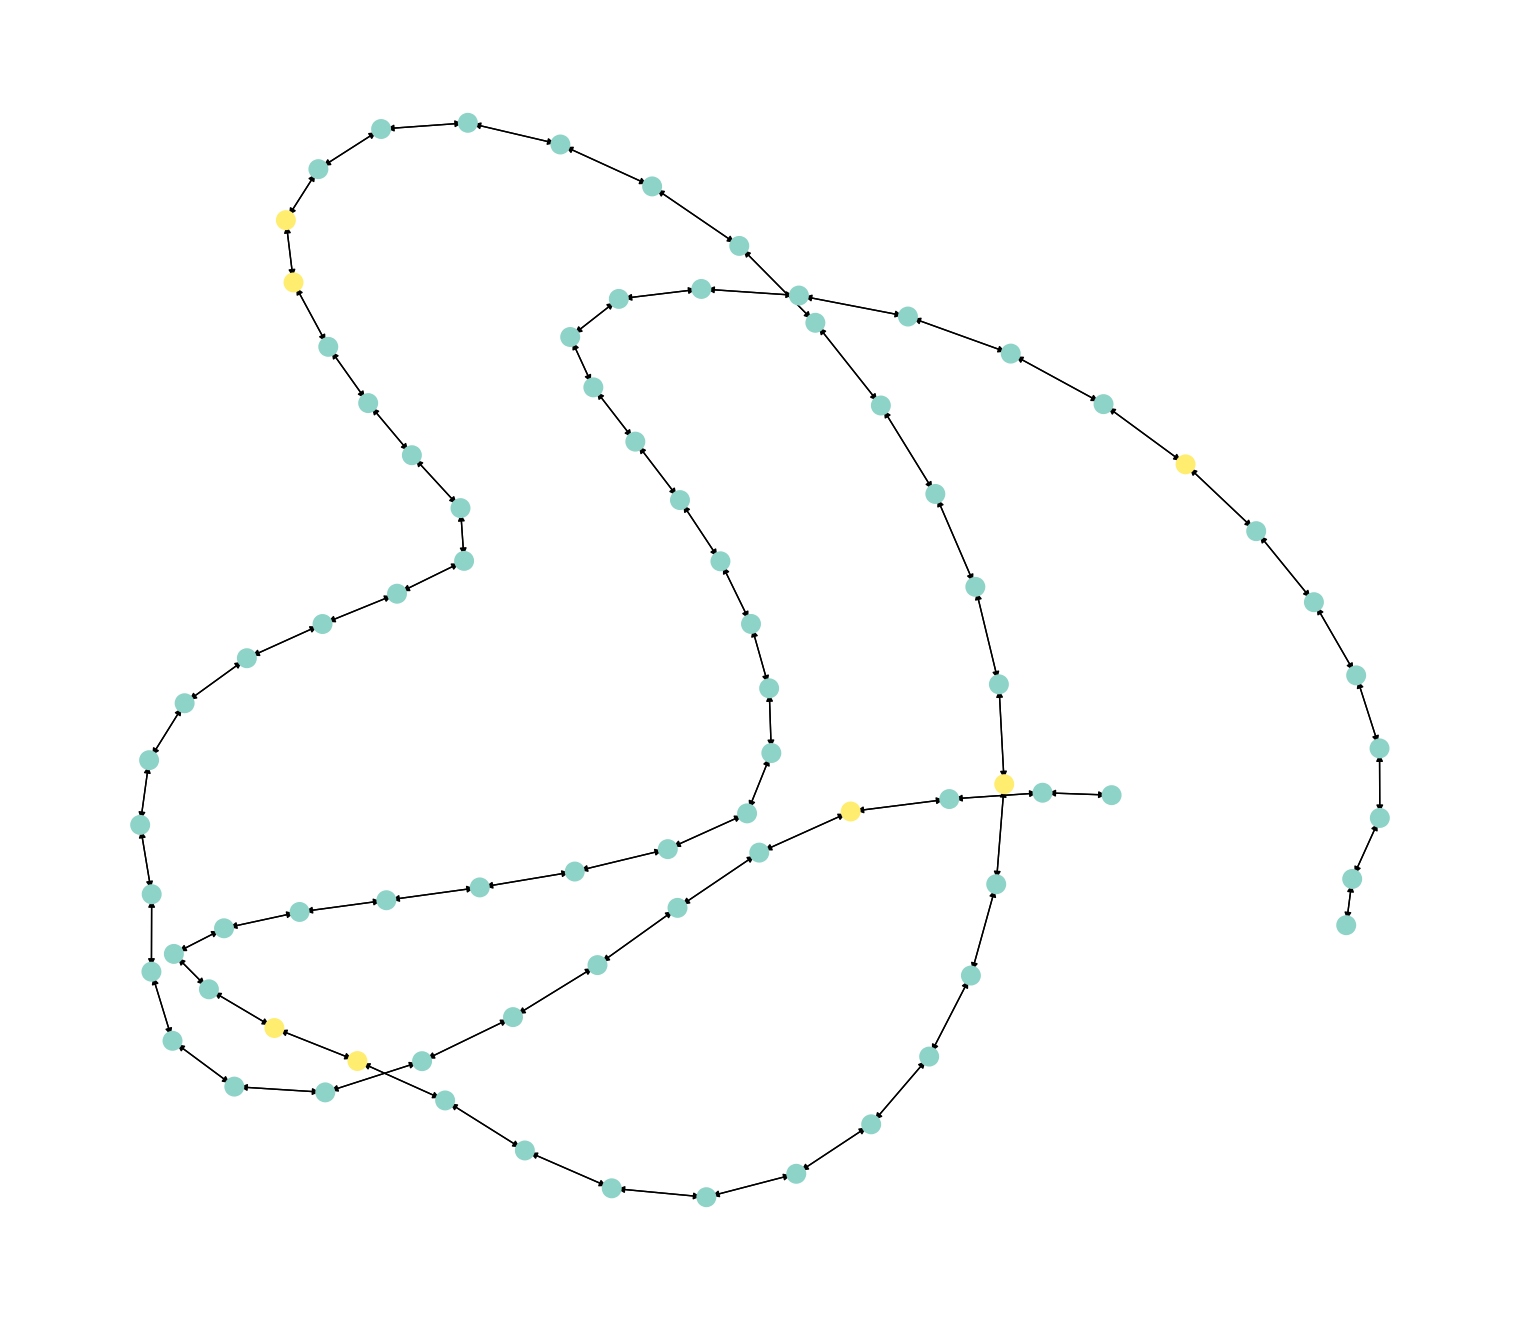

In [ ]:
graph = DataItem(100)
vis = to_networkx(graph)
node_labels = graph.y.numpy()
import matplotlib.pyplot as plt
plt.figure(1,figsize=(15,13))
nx.draw(vis, cmap=plt.get_cmap('Set3'),node_color = node_labels,node_size=70,linewidths=6)
plt.show()


In [ ]:
train_dataset = []
val_dataset = []
from tqdm.notebook import tqdm
for i in tqdm(range(1, int(0.95 * NUM_FILES) + 1)):
  train_dataset.append(DataItem(i))
for i in tqdm(range(int(0.95 * NUM_FILES + 1), NUM_FILES + 1)):
  val_dataset.append(DataItem(i))

  0%|          | 0/9500 [00:00<?, ?it/s]

<ipython-input-5-351d93c2c86d>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).double()


  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
train_dataloader, val_dataloader = DataLoader(train_dataset, batch_size = 50, shuffle = True), DataLoader(val_dataset, batch_size = 50)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
from torch_geometric.nn import GATConv
class GATModel(nn.Module):
  def __init__(self):
    super(GATModel, self).__init__()
    self.conv1 = GATConv(
        in_channels = 9,
        out_channels = 24,
        heads = 8,
        dropout = 0.2
    )
    self.conv2 = GATConv(
        in_channels = 24 * 8,
        out_channels = 2,
        concat  = False
    )

  def forward(self, data):
    x, edge_index = data.x, data.edge_index
    type(x)
    # x = torch.tensor(x)
    x = self.conv1(x, edge_index)
    x = torch.nn.ELU()(x)
    x = self.conv2(x, edge_index = edge_index)


    return nn.LogSoftmax(dim = 1)(x)






In [ ]:
model = GATModel()

model.double()

GATModel(
  (conv1): GATConv(9, 24, heads=8)
  (conv2): GATConv(192, 2, heads=1)
)

In [ ]:
from tqdm.notebook import tqdm
def train(model, optimizer, criterion):
  model.train()
  running_loss = 0
  for batch in tqdm(train_dataloader):
    out = model(batch)
    optimizer.zero_grad()
    loss = criterion(out.double(), batch.y.long())
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  return running_loss/len(train_dataloader)

def eval(model, criterion):
  model.eval()
  running_loss = 0
  for batch in tqdm(val_dataloader):
    out = model(batch)
    loss = criterion(out.double(), batch.y.long())
    running_loss += loss.item()
  return running_loss/len(val_dataloader)





In [ ]:
# best_valid_loss = np.Inf
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
criterion = nn.NLLLoss()
tl =[]
vl = []
for epoch in range(30):
  train_loss = train(model, optimizer, criterion)
  tl.append(train_loss)
  valid_loss = eval(model, criterion)
  vl.append(valid_loss)
  if valid_loss < best_valid_loss:
    print(f'Validation Loss improved from {best_valid_loss} to {valid_loss}')
    print(f'Saving Model')
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'GNN_Model.pt')
    print(f'SUCCESS')

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Validation Loss improved from 0.08968483489825078 to 0.08921592042518481
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Validation Loss improved from 0.08921592042518481 to 0.08895849556239675
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Validation Loss improved from 0.08895849556239675 to 0.08857025566237589
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Validation Loss improved from 0.08857025566237589 to 0.0883843988373339
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Validation Loss improved from 0.0883843988373339 to 0.08836838829527548
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Validation Loss improved from 0.08836838829527548 to 0.08832262587531095
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Validation Loss improved from 0.08832262587531095 to 0.08804100434502261
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Validation Loss improved from 0.08804100434502261 to 0.08774990087995718
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Validation Loss improved from 0.08774990087995718 to 0.08733133778637929
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
model.load_state_dict(torch.load('GNN_Model.pt'))

<All keys matched successfully>

In [ ]:
def calculateAccuracy(model, dataloader):
  model.eval()
  tp, tn, fp, fn = 0, 0, 0, 0
  for batch in dataloader:
    out = model(batch)
    out = out.detach()
    out = out.argmax(axis = 1)
    tp += torch.sum((out == 1) & (batch.y.long() == 1))
    tn += torch.sum((out == 0) & (batch.y.long() == 0))
    fp += torch.sum((out == 0) & (batch.y.long() == 1))
    fn += torch.sum((out == 1) & (batch.y.long() == 0))
  return tp, tn, fp, fn



Accuracy is Good, but precision is poor. Need to improve precision than that of recall


In [ ]:
tp, tn, fp, fn = calculateAccuracy(model, val_dataloader)
prec = tp*100/(tp + fp)
rec = tp * 100/(tp + fn)
print(f'Accuracy : {(tp + tn)*100/(tp + tn + fp + fn) : 0.2f}%')
print(f'Precision : {prec : 0.2f}%')
print(f'Recall : {rec : 0.2f}%')
print(f'F1 score : {2 * (rec * prec)/(rec + prec) : 0.2f}%')

Accuracy :  97.08%
Precision :  67.97%
Recall :  83.66%
F1 score :  75.01%


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torch_geometric.nn import GATConv
class GATModelNew(nn.Module):
  def __init__(self):
    super(GATModelNew, self).__init__()
    self.conv1 = GATConv(
        in_channels = 9,
        out_channels = 32,
        heads = 10,
        dropout = 0.2
    )
    self.conv2 = GATConv(
        in_channels = 32 * 10,
        out_channels = 1,
        concat  = False
    )

  def forward(self, data):
    x, edge_index = data.x, data.edge_index
    # x = torch.tensor(x)
    x = self.conv1(x, edge_index)
    x = torch.nn.ELU()(x)
    x = self.conv2(x, edge_index = edge_index)
    x = nn.Sigmoid()(x)
    return x






In [ ]:
model = GATModelNew()
model.double()

model.to(device)

GATModelNew(
  (conv1): GATConv(9, 32, heads=10)
  (conv2): GATConv(320, 1, heads=1)
)

In [ ]:
from tqdm.notebook import tqdm
def train(model, optimizer, criterion):
  model.train()
  running_loss = 0
  for batch in tqdm(train_dataloader):
    batch = batch.to(device)
    out = model(batch)
    out = out.squeeze(1)
    optimizer.zero_grad()
    if device == 'cpu':
      loss = criterion(out.double(), batch.y.long())
    else:
      loss = criterion(out.double(), batch.y.double())
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  return running_loss/len(train_dataloader)

def eval(model, criterion):
  model.eval()
  running_loss = 0
  for batch in tqdm(val_dataloader):
    batch = batch.to(device)
    out = model(batch)
    out = out.squeeze(1)
    if device == 'cpu':
      loss = criterion(out.double(), batch.y.long())
    else:
      loss = criterion(out.double(), batch.y.double())
    running_loss += loss.item()
  return running_loss/len(val_dataloader)





In [ ]:
weights = torch.tensor([0.3, 0.7])
def weightedCrossEntropyLoss(x, y):
  # print(x.shape, y.shape)
  x = torch.clamp(x, min = 1e-7, max = 1-1e-7)
  return torch.mean(-weights[1] * y * torch.log(x)  - weights[0] * (1 - y) * torch.log(1 - x))

In [ ]:
best_valid_loss = np.Inf
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
criterion = nn.BCELoss()
tl =[]
vl = []
for epoch in range(30):
  train_loss = train(model, optimizer, criterion)
  tl.append(train_loss)
  valid_loss = eval(model, criterion)
  vl.append(valid_loss)
  print(f'Epoch : {epoch + 1}, Training Loss : {train_loss : 0.4f}, Validation Loss : {valid_loss : 0.4f}')
  if valid_loss < best_valid_loss:
    print(f'Validation Loss improved from {best_valid_loss} to {valid_loss}')
    print(f'Saving Model')
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'GNN_ModelNew.pt')
    print(f'SUCCESS')

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 1, Training Loss :  0.2343, Validation Loss :  0.2222
Validation Loss improved from inf to 0.22217780311126326
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 2, Training Loss :  0.2003, Validation Loss :  0.1504
Validation Loss improved from 0.22217780311126326 to 0.1503814581164118
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 3, Training Loss :  0.1477, Validation Loss :  0.1232
Validation Loss improved from 0.1503814581164118 to 0.12324132872384248
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 4, Training Loss :  0.1326, Validation Loss :  0.1178
Validation Loss improved from 0.12324132872384248 to 0.11781398227146203
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 5, Training Loss :  0.1269, Validation Loss :  0.1173
Validation Loss improved from 0.11781398227146203 to 0.11725874012639197
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 6, Training Loss :  0.1230, Validation Loss :  0.1154
Validation Loss improved from 0.11725874012639197 to 0.11535986552242203
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 7, Training Loss :  0.1193, Validation Loss :  0.1126
Validation Loss improved from 0.11535986552242203 to 0.11259174067755762
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 8, Training Loss :  0.1164, Validation Loss :  0.1113
Validation Loss improved from 0.11259174067755762 to 0.11132883929816868
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 9, Training Loss :  0.1141, Validation Loss :  0.1111
Validation Loss improved from 0.11132883929816868 to 0.1110541513000112
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 10, Training Loss :  0.1125, Validation Loss :  0.1098
Validation Loss improved from 0.1110541513000112 to 0.10978043783451438
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 11, Training Loss :  0.1097, Validation Loss :  0.1084
Validation Loss improved from 0.10978043783451438 to 0.10840288562754945
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 12, Training Loss :  0.1083, Validation Loss :  0.1088


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 13, Training Loss :  0.1068, Validation Loss :  0.1068
Validation Loss improved from 0.10840288562754945 to 0.1067932419005568
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 14, Training Loss :  0.1057, Validation Loss :  0.1064
Validation Loss improved from 0.1067932419005568 to 0.1063856115625819
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 15, Training Loss :  0.1043, Validation Loss :  0.1055
Validation Loss improved from 0.1063856115625819 to 0.10554028372435328
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 16, Training Loss :  0.1038, Validation Loss :  0.1055


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 17, Training Loss :  0.1027, Validation Loss :  0.1044
Validation Loss improved from 0.10554028372435328 to 0.10435359889301621
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 18, Training Loss :  0.1012, Validation Loss :  0.1042
Validation Loss improved from 0.10435359889301621 to 0.10422243350754848
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 19, Training Loss :  0.1004, Validation Loss :  0.1031
Validation Loss improved from 0.10422243350754848 to 0.10310529723763093
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 20, Training Loss :  0.1001, Validation Loss :  0.1021
Validation Loss improved from 0.10310529723763093 to 0.10213065804912605
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 21, Training Loss :  0.0983, Validation Loss :  0.1015
Validation Loss improved from 0.10213065804912605 to 0.1015457445101623
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 22, Training Loss :  0.0971, Validation Loss :  0.1010
Validation Loss improved from 0.1015457445101623 to 0.10103171897549193
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 23, Training Loss :  0.0963, Validation Loss :  0.0993
Validation Loss improved from 0.10103171897549193 to 0.09934371095310321
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 24, Training Loss :  0.0958, Validation Loss :  0.0983
Validation Loss improved from 0.09934371095310321 to 0.09826478613787694
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 25, Training Loss :  0.0947, Validation Loss :  0.0975
Validation Loss improved from 0.09826478613787694 to 0.09754596798742465
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 26, Training Loss :  0.0937, Validation Loss :  0.0972
Validation Loss improved from 0.09754596798742465 to 0.09722518510540228
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 27, Training Loss :  0.0930, Validation Loss :  0.0961
Validation Loss improved from 0.09722518510540228 to 0.09613756789028366
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 28, Training Loss :  0.0925, Validation Loss :  0.0961
Validation Loss improved from 0.09613756789028366 to 0.09609470147059138
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 29, Training Loss :  0.0922, Validation Loss :  0.0963


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 30, Training Loss :  0.0917, Validation Loss :  0.0951
Validation Loss improved from 0.09609470147059138 to 0.09505091992783936
Saving Model
SUCCESS


In [ ]:
model.load_state_dict(torch.load('GNN_ModelNew.pt'))

<All keys matched successfully>

In [ ]:
def calculateAccuracy(model, dataloader):
  model.eval()
  tp, tn, fp, fn = 0, 0, 0, 0
  for batch in tqdm(dataloader):
    batch = batch.to(device)
    out = model(batch)
    out = out.detach().cpu()
    out = out.squeeze(1)
    # print(out.shape, batch.y.shape)
    # break
    tp += torch.sum((out > 0.1) & (batch.y.cpu().long() == 1))
    tn += torch.sum((out < 0.1) & (batch.y.cpu().long() == 0))
    fn += torch.sum((out < 0.1) & (batch.y.cpu().long() == 1))
    fp += torch.sum((out > 0.1) & (batch.y.cpu().long() == 0))
  return tp, tn, fp, fn



In [ ]:
tp, tn, fp, fn = calculateAccuracy(model, val_dataloader)
print(tp, tn,fp, fn)
prec = tp*100/(tp + fp)s
rec = tp * 100/(tp + fn)
print(f'Accuracy : {(tp + tn)*100/(tp + tn + fp + fn) : 0.2f}%')
print(f'Precision : {prec : 0.2f}%')
print(f'Recall : {rec : 0.2f}%')
print(f'F1 score : {2 * (rec * prec)/(rec + prec) : 0.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

tensor(2426) tensor(37597) tensor(904) tensor(225)
Accuracy :  97.26%
Precision :  72.85%
Recall :  91.51%
F1 score :  81.12%


In [ ]:
best_valid_loss = np.Inf
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
criterion = weightedCrossEntropyLoss
tl =[]
vl = []
for epoch in range(30):
  train_loss = train(model, optimizer, criterion)
  tl.append(train_loss)
  valid_loss = eval(model, criterion)
  vl.append(valid_loss)
  print(f'Epoch : {epoch + 1}, Training Loss : {train_loss : 0.4f}, Validation Loss : {valid_loss : 0.4f}')
  if valid_loss < best_valid_loss:
    print(f'Validation Loss improved from {best_valid_loss} to {valid_loss}')
    print(f'Saving Model')
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'GNN_ModelNewWeighted.pt')
    print(f'SUCCESS')

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 1, Training Loss :  0.0415, Validation Loss :  0.0438
Validation Loss improved from inf to 0.043774751101833445
Saving Model
SUCCESS


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 2, Training Loss :  0.0414, Validation Loss :  0.0442


  0%|          | 0/190 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
model.load_state_dict(torch.load('GNN_ModelNewWeighted.pt'))

<All keys matched successfully>

In [ ]:
tp, tn, fp, fn = calculateAccuracy(model, val_dataloader)
print(tp, tn,fp, fn)
prec = tp*100/(tp + fp)
rec = tp * 100/(tp + fn)
print(f'Accuracy : {(tp + tn)*100/(tp + tn + fp + fn) : 0.2f}%')
print(f'Precision : {prec : 0.2f}%')
print(f'Recall : {rec : 0.2f}%')
print(f'F1 score : {2 * (rec * prec)/(rec + prec) : 0.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

tensor(2386) tensor(37676) tensor(825) tensor(265)
Accuracy :  97.35%
Precision :  74.31%
Recall :  90.00%
F1 score :  81.41%
